In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
print(sys.executable)

/opt/miniconda3/envs/mixb/bin/python


In [4]:
def load_and_melt(file_path, value_name):
    """
    加载CSV文件并检查年份列中的无效值
    
    参数:
        file_path (str): CSV文件路径
        value_name (str): 要创建的指标名称
    
    返回:
        DataFrame: 处理后的数据框
    """
    # 读取CSV文件
    df = pd.read_csv(file_path)
    
    # 清理未命名列
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # 转换为长格式
    melted = df.melt(
        id_vars='Countries',
        var_name='Year',
        value_name=value_name
    )
    
    # 尝试将年份转换为数值，无效值设为NaN
    melted['Year_numeric'] = pd.to_numeric(melted['Year'], errors='coerce')
    
    # 查找无效年份值
    invalid_mask = melted['Year_numeric'].isna()
    invalid_rows = melted[invalid_mask]
    
    # 如果有无效值，打印详细信息
    if not invalid_rows.empty:
        print(f"\n⚠️ 在文件 {file_path} 中发现无效年份值:")
        for idx, row in invalid_rows.iterrows():
            print(f"  行索引: {idx}, 国家: '{row['Countries']}', 无效年份值: '{row['Year']}'")
        print(f"共发现 {len(invalid_rows)} 个无效年份值\n")
    
    # 删除无效行并转换年份为整数
    melted = melted.dropna(subset=['Year_numeric'])
    melted['Year'] = melted['Year_numeric'].astype(int)
    melted = melted.drop(columns=['Year_numeric'])
    
    return melted

'''
def load_and_melt(file_path, value_name):
    """
    读取文件并转换为长格式（Country, Year, Value）
    """
    # 读取文件，第一列为国家名称
    df = pd.read_csv(file_path)   
    # 转换为长格式
    melted = df.melt(
        id_vars='Countries',
        var_name='Year',
        value_name=value_name
    )
    melted['Year'] = melted['Year'].astype(int)  # 确保年份为整数
    return melted
'''
# 示例：加载 CE 数据
ce_df = load_and_melt('Data1/processed/CO2EmissionsFromEnergy.csv', value_name='CE')
ce_df

,Countries,Year,CE
0,Canada,1965,260.3
1,Mexico,1965,62.1
2,US,1965,3451.9
3,Argentina,1965,82.2
4,Brazil,1965,51.5
...,...,...,...
5331,Sri Lanka,2022,19.9
5332,Taiwan,2022,272.4
5333,Thailand,2022,275.3
5334,Vietnam,2022,270


In [5]:
# 定义文件路径及其对应的指标名
file_config = {
    'Data1/processed/CO2EmissionsFromEnergy.csv': 'total_CE',
    'Data1/processed/CarbonSequestration.csv': 'cement_CS',
    'Data1/processed/PrimaryEnergyConsumption.csv': 'energy_consumption',
    'Data1/processed/Population.csv': 'Population',
    'Data1/processed/GDP.csv': 'GDP',
    'Data1/processed/CementProduction.csv': 'cement_production',
    'Data1/processed/CementConsumption.csv': 'cement_consumption(volume)'
}

In [8]:
# 初始化合并后的 DataFrame
merged_df = None

# 逐个加载并合并
for file, col_name in file_config.items():
    print(f"处理文件: {file}")
    temp_df = load_and_melt(file, col_name)  # 使用修改后的函数
    
    if merged_df is None:
        merged_df = temp_df
        print(f"  初始数据框大小: {merged_df.shape}")
    else:
        before_merge = merged_df.shape[0]
        merged_df = pd.merge(
            merged_df,
            temp_df, 
            on=['Countries', 'Year'],  # 注意列名是'Countries'而不是'Country'
            how='inner'
        )
        after_merge = merged_df.shape[0]
        print(f"  合并后数据框大小: {merged_df.shape}, 减少行数: {before_merge - after_merge}")

# 按国家和年份排序
merged_df = merged_df.sort_values(['Countries', 'Year']).reset_index(drop=True)
print("\n✅ 所有文件处理完成!")
print(f"最终数据框大小: {merged_df.shape}")

# --- 新增: 筛选1975年之后的数据 ---
merged_df = merged_df[merged_df['Year'] >= 1975]
print(f"筛选1975年之后的数据: {merged_df.shape}")

# 将所有数值列转换为浮点数（为后续除法计算）
numeric_cols = [
    'total_CE', 'cement_CS', 'energy_consumption', 'Population', 
    'GDP', 'cement_production', 'cement_consumption(volume)'
]

for col in numeric_cols:
    # 转换并记录无效值数量
    initial_count = len(merged_df)
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    
    invalid_count = merged_df[col].isna().sum()
    if invalid_count > 0:
        print(f"⚠️ 列 '{col}' 中发现 {invalid_count} 个无效值，已替换为NaN")
        
# 删除包含NaN的行
before_clean = len(merged_df)
merged_df = merged_df.dropna(subset=numeric_cols)
after_clean = len(merged_df)
print(f"🧹 清理无效值: 删除 {before_clean - after_clean} 行，剩余 {after_clean} 行")

merged_df



处理文件: Data1/processed/EmissionsFromCementProduction.csv
  初始数据框大小: (16856, 3)
处理文件: Data1/processed/CarbonSequestration.csv
  合并后数据框大小: (17640, 4), 减少行数: -784
处理文件: Data1/processed/PrimaryEnergyConsumption.csv
  合并后数据框大小: (4756, 5), 减少行数: 12884
处理文件: Data1/processed/Population.csv
  合并后数据框大小: (4350, 6), 减少行数: 406
处理文件: Data1/processed/GDP.csv
  合并后数据框大小: (4350, 7), 减少行数: 0
处理文件: Data1/processed/CementProduction.csv
  合并后数据框大小: (4350, 8), 减少行数: 0
处理文件: Data1/processed/CementConsumption.csv
  合并后数据框大小: (2475, 9), 减少行数: 1875

✅ 所有文件处理完成!
最终数据框大小: (2475, 9)
筛选1975年之后的数据: (2475, 9)
⚠️ 列 'GDP' 中发现 10 个无效值，已替换为NaN
🧹 清理无效值: 删除 10 行，剩余 2465 行


,Countries,Year,total_CE,cement_CS,energy_consumption,Population,GDP,cement_production,cement_consumption(volume)
0,Algeria,1990,2.934434,0.946670,1.13,25518074.0,6.204851e+10,6503.19,6.503190
1,Algeria,1991,2.841711,0.940069,1.12,26133905.0,4.571568e+10,6319.00,6.319000
2,Algeria,1992,2.868403,1.075461,1.15,26748303.0,4.800313e+10,6400.00,7.983312
3,Algeria,1993,2.858669,1.097931,1.07,27354327.0,4.994558e+10,6400.00,7.826559
4,Algeria,1994,2.697585,1.141155,1.09,27937006.0,4.254318e+10,6060.00,8.234887
...,...,...,...,...,...,...,...,...,...
2470,Uzbekistan,2018,3.544944,2.233903,1.92,32956100.0,5.287011e+10,9200.00,12.681282
2471,Uzbekistan,2019,4.234667,2.493189,1.92,33580350.0,6.028350e+10,10990.00,14.112931
2472,Uzbekistan,2020,4.831913,2.682688,1.91,34232050.0,6.022470e+10,12540.00,14.884735
2473,Uzbekistan,2021,5.779800,2.804464,2.03,34915100.0,6.960061e+10,15000.00,14.859030


In [9]:
merged_df

,Countries,Year,total_CE,cement_CS,energy_consumption,Population,GDP,cement_production,cement_consumption(volume)
0,Algeria,1990,2.934434,0.946670,1.13,25518074.0,6.204851e+10,6503.19,6.503190
1,Algeria,1991,2.841711,0.940069,1.12,26133905.0,4.571568e+10,6319.00,6.319000
2,Algeria,1992,2.868403,1.075461,1.15,26748303.0,4.800313e+10,6400.00,7.983312
3,Algeria,1993,2.858669,1.097931,1.07,27354327.0,4.994558e+10,6400.00,7.826559
4,Algeria,1994,2.697585,1.141155,1.09,27937006.0,4.254318e+10,6060.00,8.234887
...,...,...,...,...,...,...,...,...,...
2470,Uzbekistan,2018,3.544944,2.233903,1.92,32956100.0,5.287011e+10,9200.00,12.681282
2471,Uzbekistan,2019,4.234667,2.493189,1.92,33580350.0,6.028350e+10,10990.00,14.112931
2472,Uzbekistan,2020,4.831913,2.682688,1.91,34232050.0,6.022470e+10,12540.00,14.884735
2473,Uzbekistan,2021,5.779800,2.804464,2.03,34915100.0,6.960061e+10,15000.00,14.859030


In [11]:
# 数据整理
# 定义分解所需的因子列名
factors = [
    'cement_CS/cement_consumption(volume)',
    'cement_consumption(volume)/cement_production',
    'cement_production/GDP',
    'GDP/Population',
    'Population/energy_consumption',
    'energy_consumption/total_CE'
]

# 在计算分解因子前添加单位转换
print("执行单位转换...")
# 质量单位转换 (水泥产量: kt → Mt) 百万吨
merged_df['cement_production'] = merged_df['cement_production'] / 1000
# 经济单位转换 (GDP: USD → trillion USD) 万亿美元
merged_df['GDP'] = merged_df['GDP'] / 1e12
# 人口单位转换 (persons → billion persons) 人口(亿人)
merged_df['Population'] = merged_df['Population'] / 1e8
# 现在计算分解因子（使用统一单位）
print("计算分解因子...")

# 计算各分解因子
merged_df['cement_CS/cement_consumption(volume)'] = merged_df['cement_CS'] / merged_df['cement_consumption(volume)']
merged_df['cement_consumption(volume)/cement_production'] = merged_df['cement_consumption(volume)'] / merged_df['cement_production']
merged_df['cement_production/GDP'] = merged_df['cement_production'] / merged_df['GDP']
merged_df['GDP/Population'] = merged_df['GDP'] / merged_df['Population']
merged_df['Population/energy_consumption'] = merged_df['Population'] / merged_df['energy_consumption']
merged_df['energy_consumption/total_CE'] = merged_df['energy_consumption'] / merged_df['total_CE']

# 确保所有关键列均为正数（避免对非正值取对数）
merged_df = merged_df[
    (merged_df['total_CE'] > 0) &
    (merged_df['cement_CS'] > 0) &
    (merged_df['cement_consumption(volume)'] > 0) &
    (merged_df['cement_production'] > 0) &
    (merged_df['GDP'] > 0) &
    (merged_df['Population'] > 0)&
    (merged_df['energy_consumption'] > 0) 
]

# 再次检查无穷大和缺失值
print("清理无穷值和缺失值...")
merged_df = merged_df.replace([np.inf, -np.inf], np.nan)
merged_df = merged_df.dropna(subset=factors + ['total_CE', 'cement_CS'])
print(f"🧮 最终有效数据量: {len(merged_df)} 行 (1975年之后)")
print(f"🗺️ 最终有效国家列表: {merged_df["Countries"].unique()}")
merged_df[merged_df["Countries"] == "China"]

执行单位转换...
计算分解因子...
清理无穷值和缺失值...
🧮 最终有效数据量: 2401 行 (1975年之后)
🗺️ 最终有效国家列表: ['Algeria' 'Argentina' 'Australia' 'Austria' 'Azerbaijan' 'Bangladesh'
 'Belarus' 'Belgium' 'Brazil' 'Bulgaria' 'Canada' 'Chile' 'China'
 'Colombia' 'Croatia' 'Cyprus' 'Czechia' 'Denmark' 'Ecuador' 'Egypt'
 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Kazakhstan' 'Kuwait' 'Lithuania' 'Luxembourg' 'Malaysia' 'Mexico'
 'Morocco' 'New Zealand' 'North Macedonia' 'Norway' 'Oman' 'Pakistan'
 'Peru' 'Philippines' 'Poland' 'Portugal' 'Qatar' 'Romania' 'Saudi Arabia'
 'Slovakia' 'Slovenia' 'South Africa' 'Spain' 'Sri Lanka' 'Sweden'
 'Switzerland' 'Thailand' 'Ukraine' 'Uzbekistan']


,Countries,Year,total_CE,cement_CS,energy_consumption,Population,GDP,cement_production,cement_consumption(volume),cement_CS/cement_consumption(volume),cement_consumption(volume)/cement_production,cement_production/GDP,GDP/Population,Population/energy_consumption,energy_consumption/total_CE
495,China,1990,66.767904,28.138505,28.58,1.135185e-07,3.608580e-13,0.203168,203.168000,0.138499,1000.000000,5.630137e+11,0.000003,3.971956e-09,0.428050
496,China,1990,66.767904,28.138505,28.58,1.135185e-07,3.608580e-13,0.203168,203.168000,0.138499,1000.000000,5.630137e+11,0.000003,3.971956e-09,0.428050
497,China,1990,0.750382,28.138505,28.58,1.135185e-07,3.608580e-13,0.203168,203.168000,0.138499,1000.000000,5.630137e+11,0.000003,3.971956e-09,38.087288
498,China,1990,0.750382,28.138505,28.58,1.135185e-07,3.608580e-13,0.203168,203.168000,0.138499,1000.000000,5.630137e+11,0.000003,3.971956e-09,38.087288
499,China,1991,82.607409,33.244128,30.02,1.150780e-07,3.833730e-13,0.252610,252.610000,0.131603,1000.000000,6.589144e+11,0.000003,3.833378e-09,0.363406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,China,2021,1.782105,364.452859,157.94,1.412360e-07,1.782050e-11,2.378108,2375.940938,0.153393,999.088745,1.334479e+11,0.000126,8.942383e-10,88.625530
623,China,2022,683.833784,345.265282,159.39,1.412175e-07,1.788180e-11,2.118000,2116.039227,0.163166,999.074234,1.184445e+11,0.000127,8.859872e-10,0.233083
624,China,2022,683.833784,345.265282,159.39,1.412175e-07,1.788180e-11,2.118000,2116.039227,0.163166,999.074234,1.184445e+11,0.000127,8.859872e-10,0.233083
625,China,2022,1.688310,345.265282,159.39,1.412175e-07,1.788180e-11,2.118000,2116.039227,0.163166,999.074234,1.184445e+11,0.000127,8.859872e-10,94.408017


In [12]:
def lmdi_decomposition(df, base_year, target_ratio='cement_CS/total_CE'):
    
    """
    执行 LMDI 分解，计算各因子贡献
    - df: 合并后的数据（包含 Country, Year 和各因子）
    - base_year: 基期年份（如 1990）
    - target_ratio: 分解的目标比例（默认为 CS/CE）
    """
    
    # 计算目标比例 CSO = CS/CE
    # df[target_ratio] = df['cement_CS'] / df['total_CE']
    # 计算目标值
    df[target_ratio] = df['cement_CS'] 
    

    # 初始化结果存储
    results = []
    for country, country_df in df.groupby('Countries'):
        country_df = country_df.sort_values('Year')
        country_df = country_df[country_df['Year'] >= base_year]
        if len(country_df) < 2:
            continue

        for idx in range(1, len(country_df)):
            t_row = country_df.iloc[idx]
            b_row = country_df.iloc[idx-1]

            cfp_t = t_row[target_ratio]
            cfp_b = b_row[target_ratio]

            # 添加对 CFP 值的保护
            if cfp_t <= 0 or cfp_b <= 0:
                continue  # 跳过非正值

            # 计算 L(CFP^t, CFP^b)
            if np.isclose(cfp_t, cfp_b, rtol=1e-6):  # 浮点数精度容错
                L = cfp_t
            else:
                log_diff = np.log(cfp_t) - np.log(cfp_b)
                if np.isclose(log_diff, 0):  # 防止除以零
                    L = cfp_t
                else:
                    L = (cfp_t - cfp_b) / log_diff

            # 计算各因子贡献（添加对 ratio_t/ratio_b 的保护）
            contributions = {}
            for factor in factors:
                ratio_t = t_row[factor]
                ratio_b = b_row[factor]
                if ratio_t <= 0 or ratio_b <= 0:
                    contributions[f'Δ{factor}'] = np.nan
                else:
                    contributions[f'Δ{factor}'] = L * np.log(ratio_t / ratio_b)
            
            # 跳过存在 NaN 的行
            if not np.isnan(list(contributions.values())).any():
                results.append({
                    'Countries': country,
                    'Year': t_row['Year'],
                    'ΔTotal': cfp_t - cfp_b,
                    **contributions
                })
    
    return pd.DataFrame(results)

In [13]:
# 设置基期年份（根据数据实际起始时间调整）
base_year = 1975  # 示例

# 运行分解
lmdi_results = lmdi_decomposition(merged_df, base_year)

# 保存结果
lmdi_results.to_csv('Data1/results/LMDI_Contributions.csv', index=False, encoding='utf-8-sig')

# 查看示例输出
print(lmdi_results.head())

  Countries  Year    ΔTotal  Δcement_CS/cement_consumption(volume)  \
0   Algeria  1991  0.008203                               0.007100   
1   Algeria  1992  0.044123                              -0.034974   
2   Algeria  1993  0.009137                               0.015373   
3   Algeria  1994  0.038957                              -0.004937   
4   Algeria  1995 -0.000201                               0.008420   

   Δcement_consumption(volume)/cement_production  Δcement_production/GDP  \
0                                       0.000000                0.090410   
1                                       0.077903               -0.012718   
2                                      -0.007525               -0.015053   
3                                       0.042519                0.042673   
4                                      -0.010069                0.017474   

   ΔGDP/Population  ΔPopulation/energy_consumption  \
0        -0.107587                        0.010694   
1         0.00

In [14]:
# 验证：
lmdi_results['ΔSum'] = lmdi_results[[f'Δ{factor}' for factor in factors]].sum(axis=1)
print(lmdi_results[['ΔTotal', 'ΔSum']].head())

     ΔTotal      ΔSum
0  0.008203  0.008203
1  0.044123  0.044123
2  0.009137  0.009137
3  0.038957  0.038957
4 -0.000201 -0.000201


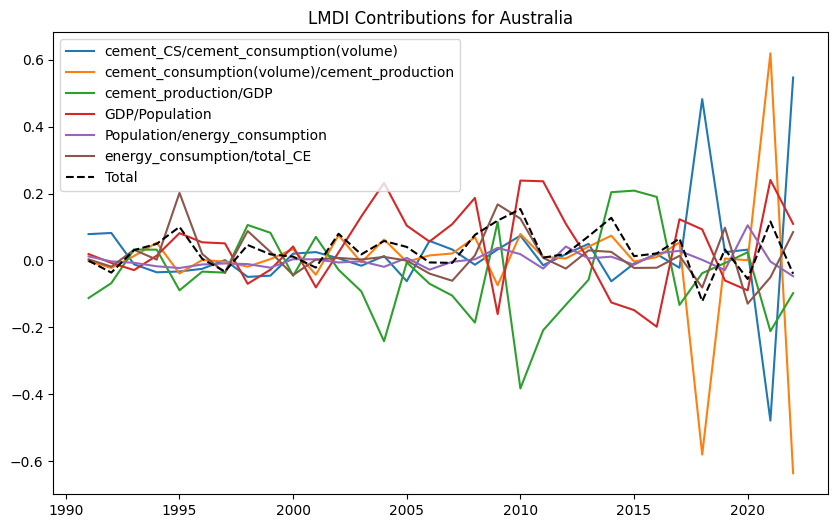

In [15]:
country = 'Australia'
df_country = lmdi_results[lmdi_results['Countries'] == country]

plt.figure(figsize=(10, 6))
for factor in factors:
    plt.plot(df_country['Year'], df_country[f'Δ{factor}'], label=factor)
plt.plot(df_country['Year'], df_country['ΔTotal'], 'k--', label='Total')
plt.title(f'LMDI Contributions for {country}')
plt.legend()
plt.show()

## 分解20年

In [16]:
def lmdi_decomposition_single_period(df, base_year, target_ratio='cement_CS/total_CE'):
    """
    执行LMDI分解（每个国家只计算最新一年与最开始一年的对比）
    - df: 合并后的数据（包含Country, Year和各因子）
    - base_year: 基期年份（如1975）
    - target_ratio: 分解的目标比例（默认为CS/CE）
    """
    # 计算目标比例
    df[target_ratio] = df['cement_CS'] / df['total_CE']
    
    # 初始化结果存储
    results = []
    for country, country_df in df.groupby('Countries'):
        # 筛选基期之后的数据并按年份排序
        country_df = country_df[country_df['Year'] >= base_year].sort_values('Year')
        # if len(country_df) < 2:
        #    continue  # 至少需要首尾两年数据
        
        # 获取首尾两年数据
        first_row = country_df.iloc[0]    # 最开始一年（>= base_year的最早年份）
        last_row = country_df.iloc[-1]    # 最新一年
        
        cfp_first = first_row[target_ratio]
        cfp_last = last_row[target_ratio]

        # 跳过非正值
        # if cfp_first <= 0 or cfp_last <= 0:
        #    continue

        # 计算L(CFP_last, CFP_first)
        if np.isclose(cfp_last, cfp_first, rtol=1e-6):
            L = cfp_last
        else:
            log_diff = np.log(cfp_last) - np.log(cfp_first)
            L = (cfp_last - cfp_first) / log_diff if not np.isclose(log_diff, 0) else cfp_last

        # 计算各因子贡献
        contributions = {}
        for factor in factors:
            ratio_first = first_row[factor]
            ratio_last = last_row[factor]
            if ratio_first <= 0 or ratio_last <= 0:
                contributions[f'Δ{factor}'] = np.nan
            else:
                contributions[f'Δ{factor}'] = L * np.log(ratio_last / ratio_first)
        
        # 保存结果（每个国家一条记录）
        if not np.isnan(list(contributions.values())).any():
            results.append({
                'Countries': country,
                'Start_Year': first_row['Year'],
                'End_Year': last_row['Year'],
                'ΔTotal': cfp_last - cfp_first,  # 总变化量
                **contributions
            })
    
    return pd.DataFrame(results)

In [17]:
# 运行分解（每个国家输出首尾年对比）
lmdi_results = lmdi_decomposition_single_period(merged_df, base_year=1975)

# 保存结果
lmdi_results.to_csv('Data1/results/LMDI_Contributions_FirstLast.csv', index=False)

# 查看示例输出
print(lmdi_results.head())

    Countries  Start_Year  End_Year    ΔTotal  \
0     Algeria        1990      2022  0.032976   
1   Argentina        1990      2022  0.052702   
2   Australia        1990      2022  0.965300   
3     Austria        1990      2022  0.335549   
4  Azerbaijan        1990      2022 -0.098597   

   Δcement_CS/cement_consumption(volume)  \
0                              -0.007408   
1                               0.003005   
2                               0.534806   
3                               0.117580   
4                              -0.019760   

   Δcement_consumption(volume)/cement_production  Δcement_production/GDP  \
0                                   0.000000e+00                0.057344   
1                                   4.178591e-07               -0.389933   
2                                   1.850464e-03               -1.335219   
3                                   7.427532e-02               -0.429064   
4                                  -9.499071e-02            